In [2]:
import datetime
import sys
import os
import torch
import numpy as np
import random
from pathlib import Path
from collections import namedtuple
from miditok import REMI, MMM
from torch.nn import functional as F
from importlib import reload

os.chdir('/home/nico/dev/projects/ai/musai')

sys.path.append('./src/tools')
sys.path.append('./src/model')

import tokenizer

reload(tokenizer)

from tokenizer import get_tokenizer, parse_bpe_tokens, TOKEN_PARAMS_NAME

PROJ_NAME = 'all'
IS_BPE = False
TOKENS_PATH = f"/media/nico/nvme/data/tokens/tmp{'/bpe' if IS_BPE else ''}"
TOKENS_FILE_PATHS = list(Path(TOKENS_PATH).glob('*.json'))
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CTX_LEN = 1024
PRECISION = 'bf16'

os.environ['RWKV_T_MAX'] = str(CTX_LEN)
os.environ['RWKV_FLOAT_MODE'] = PRECISION

os.getcwd()

/home/nico/.pyenv/versions/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-03 18:42:38,420	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


'/home/nico/dev/projects/ai/musai'

In [ ]:
DEVICE

In [3]:
TOKENIZER = get_tokenizer(params=f'{TOKENS_PATH}/{TOKEN_PARAMS_NAME}')

Path(f'./out/{PROJ_NAME}').mkdir(parents=True, exist_ok=True)

ORIG_VOCAB_SIZE = len(TOKENIZER.vocab)
BPE_VOCAB_SIZE = int(ORIG_VOCAB_SIZE * 1.25)

(ORIG_VOCAB_SIZE, BPE_VOCAB_SIZE, len(TOKENIZER))

/home/nico/.pyenv/versions/llm/lib/python3.12/site-packages/miditok/tokenizations/remi.py:77: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)
2025-02-03 18:42:41.239 | INFO     | tokenizer:get_tokenizer:298 - Tokenizer initialized. Using REMI (655)


(655, 818, 655)

In [4]:
N_EMBED = 768
N_LAYER = 12

params = {
    'ctx_len': CTX_LEN,
    'n_embd': N_EMBED,
    'n_layer': N_LAYER,
}

params_obj = namedtuple('RWKVParams', params.keys())(*params.values())

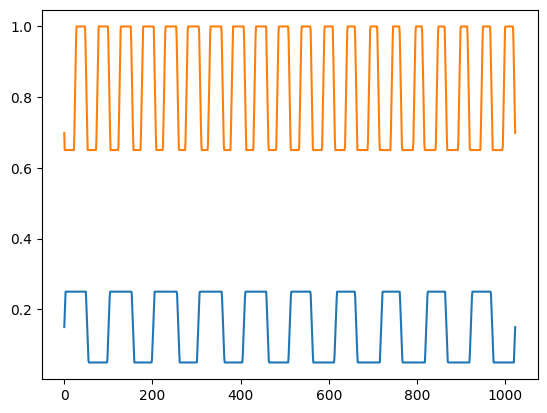

In [5]:
import matplotlib.pyplot as plt

MAX_ITER = CTX_LEN

# this is where we introduce some randomness
NOISE_LEVEL = 0.55
NOISE_FREQ = 10
PHASE = 0


def gen_sin_wave(total_iterations, min_value, max_value, noise_scale, noise_frequency, main_phase):
    """
    Generate a sinusoidal wave with optional noise.

    Args:
        total_iterations (int): The total number of iterations.
        min_value (float): The minimum value of the wave.
        max_value (float): The maximum value of the wave.
        noise_scale (float): The scale factor for the noise.
        noise_frequency (float): The frequency of the noise wave.
        main_phase (float): The phase of the main wave.

    Returns:
        list: A list of generated wave values.

    """
    progress = np.linspace(0, 1, total_iterations)
    main_wave = np.sin(2 * np.pi * progress + main_phase)
    noise_wave = np.sin(2 * np.pi * noise_frequency * progress - main_phase / 2)
    noise = noise_scale * noise_wave
    values = min_value + (max_value - min_value) * \
        (1 + main_wave) / 2 + noise

    np.clip(values, min_value, max_value, out=values)

    return values.tolist()


temp_values = gen_sin_wave(MAX_ITER, 0.05, 0.25, NOISE_LEVEL, NOISE_FREQ, PHASE)
top_p_values = gen_sin_wave(MAX_ITER, 0.65, 0.999, NOISE_LEVEL, NOISE_FREQ*2, PHASE+6)

plt.plot(temp_values)
plt.plot(top_p_values)

In [6]:
import runner

reload(runner)

from runner import RWKV
import types

SEED = random.randint(1000, 10000)
np.random.seed(SEED)

args = types.SimpleNamespace()
args.RUN_DEVICE = "cuda"
args.FLOAT_MODE = PRECISION
args.map_location = 'cpu'
args.base_model = f'/home/nico/dev/projects/ai/musai/dist/main_1.pth'
args.n_layer = params['n_layer']
args.n_embd = params['n_embd']
args.ctx_len = int(params['ctx_len'])
args.vocab_size = len(TOKENIZER)
args.head_size_a = 64

model_rnn = RWKV(args)
model_rnn.to(torch.bfloat16).cuda()

model_rnn.load_state_dict(torch.load(args.base_model, map_location='cpu'), strict=False)

Using /home/nico/.cache/torch_extensions/py312_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/nico/.cache/torch_extensions/py312_cu124/wkv7/build.ninja...
/home/nico/.pyenv/versions/llm/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module wkv7...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module wkv7...
Using /home/nico/.cache/torch_extensions/py312_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module wkv7, skipping build step...
Loading extension module wkv7...


ninja: no work to do.


_IncompatibleKeys(missing_keys=['blocks.1.ln0.weight', 'blocks.1.ln0.bias', 'blocks.2.ln0.weight', 'blocks.2.ln0.bias', 'blocks.3.ln0.weight', 'blocks.3.ln0.bias', 'blocks.4.ln0.weight', 'blocks.4.ln0.bias', 'blocks.5.ln0.weight', 'blocks.5.ln0.bias', 'blocks.6.ln0.weight', 'blocks.6.ln0.bias', 'blocks.7.ln0.weight', 'blocks.7.ln0.bias', 'blocks.8.ln0.weight', 'blocks.8.ln0.bias', 'blocks.9.ln0.weight', 'blocks.9.ln0.bias', 'blocks.10.ln0.weight', 'blocks.10.ln0.bias', 'blocks.11.ln0.weight', 'blocks.11.ln0.bias'], unexpected_keys=['copy_mask', 'head_q.weight', 'head_k.weight'])

In [23]:
import json
from miditoolkit import MidiFile

init_state = None
out_tokens = []
tokens_file_paths = list(Path(TOKENS_PATH).glob('*.json'))

random.shuffle(tokens_file_paths)

# SAMPLE_TOKENS_FILE = f'/home/nico/data/ai/models/midi/{PROJ_NAME}/8f33606fa1a6040e5ba230ea7bff8546_mid.json'

token_ids = json.load(open(tokens_file_paths[0]))['ids']
# token_ids = json.load(open(SAMPLE_TOKENS_FILE))['ids']
# sample = TOKENIZER.midi_to_tokens(MidiFile('examples/2023-06-11T12-59-05-739764.mid'))
# token_ids = sample.ids
max_seq = CTX_LEN if len(token_ids) >= CTX_LEN else len(token_ids)
init_tokens = token_ids[:max_seq]
print(init_tokens)

[4, 654, 181, 584, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 557, 181, 607, 515, 607, 53, 107, 147, 607, 58, 108, 147, 607, 62, 109, 147, 542, 181, 607, 517, 607, 55, 109, 147, 607, 64, 112, 146, 607, 60, 111, 146, 542, 181, 607, 361, 607, 55, 107, 130, 607, 59, 109, 130, 607, 62, 111, 130, 543, 197, 607, 361, 607, 55, 109, 123, 607, 59, 109, 123, 607, 62, 111, 123, 542, 205, 607, 517, 607, 55, 109, 122, 607, 62, 109, 122, 607, 59, 107, 121, 548, 186, 607, 361, 607, 55, 109, 120, 607, 59, 107, 119, 607, 62, 109, 120, 544, 193, 607, 509, 607, 59, 107, 118, 607, 55, 108, 118, 607, 62, 109, 118, 543, 197, 607, 361, 607, 55, 108, 122, 607, 59, 108, 122, 607, 62, 109, 122, 543, 205, 607, 361, 607, 55, 109, 121, 607, 59, 107, 121, 607, 62, 109, 121, 544, 181, 607, 515, 607, 53, 107, 147, 607, 58, 113, 147, 607, 62, 109, 147, 543, 182, 607, 517, 607, 55, 109, 147, 607, 64, 112, 146, 607, 60, 111, 146, 4, 654, 181, 607, 65, 116, 117, 607, 77, 116, 117, 182, 607, 67,

In [ ]:
import re
import datetime
from collections import deque
import torch
import torch.nn.functional as F
from runner import repetition_penalty  # Ensure this is properly defined in your runner module
from tqdm import tqdm  # Import tqdm for the progress bar

# Define the sampling function with temperature and top_k
def sample_logits(logits, temperature=1.0, top_k=None, top_p=None):
    """
    Samples a token from the logits after applying temperature and top_k/top_p filtering.

    Args:
        logits (torch.Tensor): Logits for the current step, shape [vocab_size] or [batch_size, vocab_size].
        temperature (float): Temperature value for scaling logits.
        top_k (int, optional): Number of top tokens to keep for sampling.
        top_p (float, optional): Cumulative probability threshold for nucleus sampling.

    Returns:
        int or torch.Tensor: The sampled token ID(s).
    """
    # Ensure logits are at least 2D
    if logits.dim() == 1:
        logits = logits.unsqueeze(0)  # Shape: [1, vocab_size]

    # Apply temperature
    logits = logits / temperature

    # Apply top_k filtering
    if top_k is not None and top_k > 0:
        top_k = min(top_k, logits.size(-1))  # Safety check
        # Set logits not in top_k to -inf
        # torch.topk returns the top k elements in the last dimension
        topk_values, _ = torch.topk(logits, top_k, dim=-1)
        cutoff = topk_values[:, -1].unsqueeze(-1)
        logits = torch.where(logits < cutoff, torch.tensor(-float('inf')).to(logits.device), logits)

    # Apply top_p (nucleus) filtering
    if top_p is not None and top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above top_p
        sorted_indices_to_remove = cumulative_probs > top_p

        # Shift the indices to the right to keep at least one token
        sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
        sorted_indices_to_remove[:, 0] = 0

        # Scatter the sorted indices to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(
            dim=-1, index=sorted_indices, src=sorted_indices_to_remove
        )

        logits = logits.masked_fill(indices_to_remove, -float('inf'))

    # Convert logits to probabilities
    probs = F.softmax(logits, dim=-1)

    # Sample from the distribution
    next_token = torch.multinomial(probs, num_samples=1)

    # If original logits were 1D, return a single integer
    if next_token.size(0) == 1:
        return next_token.item()
    else:
        return next_token.squeeze(1)

# Initialize the model in evaluation mode
model_rnn.eval()

# Initialize the buffer with the initial tokens, ensuring it does not exceed context_length
context_length = 1024  # Define your context length
buffer = deque(maxlen=context_length)
for token in init_tokens[-context_length:]:
    buffer.append(token)

max_iterations = MAX_ITER  # Define your maximum number of iterations

# Container for generated tokens
generated_tokens = list(buffer)

# Convert buffer to tensor
input_ids = torch.tensor([list(buffer)], dtype=torch.long).cuda()
print(f"Input shape: {input_ids.shape}")  # Should be [1, 1024]

# Define pad token IDs to ignore (replace with actual pad token IDs)
pad_token_ids = [0]  # Example: [0, 50256]
out_tokens = []

with torch.no_grad():
    # Initial forward pass
    init_out = model_rnn.forward(input_ids)  # Shape: [1, 1024, vocab_size]
    print(f"Initial output shape: {init_out.shape}")

    # Ignore padding by setting their logits to -inf
    init_out[0, :, pad_token_ids] = -float('inf')

    # Sample the first token from the last position
    logits = init_out[0, -1, :].cpu()  # Move to CPU for sampling if necessary
    out_token = sample_logits(logits, temperature=0.25, top_k=50)  # Example values

    # Append to generated tokens
    generated_tokens.append(out_token)

    # Add the first token to out_tokens for tracking
    out_tokens.append(out_token)

    # Initialize tqdm progress bar
    with tqdm(range(max_iterations), desc="Generating tokens", unit="token") as pbar:
        for i in pbar:
            # Update buffer with the new token
            buffer.append(out_token)
            generated_tokens.append(out_token)

            # Convert buffer to tensor
            input_ids = torch.tensor([list(buffer)], dtype=torch.long).cuda()

            # Forward pass
            output = model_rnn.forward(input_ids)  # Shape: [1, 1024, vocab_size]

            # Ignore padding
            output[0, :, pad_token_ids] = -float('inf')

            # Apply repetition penalty if desired
            # Uncomment and adjust the following lines if repetition_penalty is needed
            # output = repetition_penalty(
            #     output, generated_tokens, [4, 5, 6, 7], 
            #     repetition_penalty=1.25, 
            #     seq_len=256, 
            #     decay_factor=0.8
            # )

            # Get logits for the last token
            logits = output[0, -1, :].cpu()

            # Define temperature and top_k/top_p for the current step
            current_temp = temp_values[i] if 'temp_values' in locals() else 1.0  # Replace with your logic
            current_top_k = top_k_values[i] if 'top_k_values' in locals() else 50   # Replace with your logic
            current_top_p = top_p_values[i] if 'top_p_values' in locals() else None  # Replace with your logic

            # Sample the next token
            out_token = sample_logits(
                logits, 
                temperature=current_temp, 
                top_k=current_top_k, 
                top_p=current_top_p
            )

            # Append to generated tokens
            generated_tokens.append(out_token)
            out_tokens.append(out_token)

            # Update the tqdm progress bar with the latest token
            pbar.set_postfix(token=out_token)

Input shape: torch.Size([1, 766])
Initial output shape: torch.Size([1, 766, 655])


Generating tokens:  19%|██████████████████████▎                                                                                              | 195/1024 [00:04<00:21, 39.16token/s, token=598]

In [ ]:
print(out_tokens)

In [20]:
fname = f'out/{PROJ_NAME}/{d}.mid'
fname_orig = f'out/{PROJ_NAME}/{d}_orig.mid'

TOKENIZER(out_tokens).dump_midi(fname)
TOKENIZER(token_ids).dump_midi(fname_orig)

[fname, fname_orig]

['out/all/2025-02-03T18-47-12-000031.mid',
 'out/all/2025-02-03T18-47-12-000031_orig.mid']